In [285]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from MeltModelJupyter import Model
import os
from scipy.interpolate import interp1d

# create plotsAndStats.py, make mass plot again
# remove compression choice 

In [1]:
%%javascript
function toggler(){
    if(window.already_toggling){  return 0 }
    let btn = $('.input').append('<button>Toggle</button>').children('button');
    btn.on('click', function(e){ let tgt = e.currentTarget;
        $(tgt).parent().children('.inner_cell').toggle() })
    window.already_toggling = true;}
setTimeout(toggler, 1000);

<IPython.core.display.Javascript object>

# Read Me
Orignial files 'Model_sigma.txt', 'coef.txt', 'parameter.txt', 'rho_u_S1100.dat', and 'rho_u_S3160.dat' downloaded from https://github.com/mikinakajima/MeltScalingLaw (2-24-2021). Descriptions can be found in 'melt_model.py'. \
Accretion Model adaptation from 'melt_model.py' can be found in 'MeltModelJupyter.py'.\
For more information, see https://doi.org/10.1016/j.epsl.2021.116983.

MIT License 
  

Copyright (c) 2020 Miki Nakajima 
  

Permission is hereby granted, free of charge, to any person obtaining a copy 

of this software and associated documentation files (the "Software"), to deal 

in the Software without restriction, including without limitation the rights 

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell 

copies of the Software, and to permit persons to whom the Software is 

furnished to do so, subject to the following conditions: 

  

The above copyright notice and this permission notice shall be included in all 

copies or substantial portions of the Software. 

  

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE 

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE 

SOFTWARE. 

# Accretion Model
Impacts from Mercury 6.2 are run through melt model.\
Velocities > 1.1, large gamma, or large impact angles may cause inconsistencies e.g., radius decreases between impacts.\
Melts are cooled with scheme from Nikolau 2019.\


## Accretion.py

In [71]:
from MeltModelJupyter import Model
import os
import numpy as np
from scipy.interpolate import interp1d

Settings = [line.strip() for line in open('Acc_Settings.txt')] # Defualts commented below
SimInput = len(os.listdir(Settings[2]))
SavingData = 0 # int(Settings[4])        # 1
Compressed = int(Settings[6])        # 1
stepSize = int(Settings[8])          # 365*25 days

RunSteamModel = int(Settings[12])    # 1
InitMolten = int(Settings[14])       # 0
InitH2O = int(Settings[16])          # 410 ppm
InitEnt = int(Settings[18])          # 1100 J/kg/K
F_const = float(Settings[20])        # 120w/m2 for  CO2 rich, wet atm (Halevy 2009; doi:10.1029/2009JD011915)
Lm = float(Settings[22])             # 7.18e5 J/kg
Cv = int(Settings[24])               # 1000 J/kg
Koliv = float(Settings[26])          # 0.007 

F_Solar = 60+125*RunSteamModel       # 340*0.75 = 255 for Young Sun, 15-40% albedo for cloudless steam atm -> 185, 76% albedo for venus like (Limaye; doi.org/10.1007/s11214-018-0525-2) -> 60
F_bar = [float(x) for x in [line for line in open('F_bar.dat')][1].split(',')[:-1]] # 285 w/m2 upper limit
barF = interp1d(np.arange(len(F_bar)), F_bar) #turning data into a continuous function -> useful for < 25 bar
dt = 24*3600 # seconds in a day; Epoch in days, Flux in seconds
UpCoolLim = 365*400000000 # 40 Myr upperbound

# linear interpolation functions for melt energy
def e2depth(e,sumULayer,ULayer): # surface to core
    if(e>=sumULayer[-1]*.9999): return .9999
    if(e<=0): return 0.0
    return (sum(sumULayer[1:]<e) + (e-max((sumULayer<e)*sumULayer))/ULayer[sum(sumULayer[1:]<e)])/30

def depth2e(d,sumULayer): # surface to core
    if(d>=.9999): return sumULayer[-1]*.9999
    if(d<=0): return 0.0
    return sumULayer[int(d*30)]+(d*30%1)*ULayer[int(d*30)]

print('Running Accretion Model with',RunSteamModel*(str(InitH2O)+' ppm H2O,')+(1-RunSteamModel)*(str(int(F_const))+' w/m^2 OLR,'),
      F_Solar,'w/m^2 insolation, and',InitMolten*'initially molten'+(1-InitMolten)*(str(InitEnt)+' initial entropy'),'\n',flush=True)

for sim in np.arange(5,6): #SimInput+1):
    print('Sim',sim,'\nImpact: ',end='')
# ------------ # data parsing and init; input format -> ['Name', ' Epoch', ' Angle', ' Mtotal', ' Impact_velocity', ' Gamma']
    data = np.array([[float(q) for q in x] for x in [(z[0].split(', ')[1:6]) for z in [x.split('\n') for x in open('Nakajima_Inputs/AccSim'+str(sim))][1:]]])
    dataSorted = data[data[:,0].argsort()] #sorted by impact date
        
# ------------ # Initialize arrays
    meltDSim = np.zeros(int((dataSorted[-1][0]+UpCoolLim)/stepSize)) # depth of melt
    atmBuildup = np.zeros(int((dataSorted[-1][0]+UpCoolLim)/stepSize)) # depth of melt
    mantleXw = np.ones(30)*InitH2O/1e6; meltXw = InitH2O/1e6; du_mantle = 0 # mantle water %wt, surface to core - Steam model only
    atmW = d0 = d1 = 0 # saturation pressure of H2O above magma (bar) and init depth
    if(InitMolten): d1 = .9999; InitEnt = 3160; dataSorted = np.insert(dataSorted,0,[0,0,3.1023287,1,.1]).reshape(-1,5) # dummy impact to record initial molten state and begin cooling
    
# ------------ # Running impacts    
    for k in np.arange(0,len(dataSorted)):  
# ------------ # Melt model (Nakajima 2021, doi:10.1016/j.epsl.2021.116983)            
        if(k < len(dataSorted)-InitMolten): print(k+1,end=' ',flush=True) # prevents printing of dummy impact... 
        m = Model(Mtotal=dataSorted[k][2], gamma=dataSorted[k][4], vel=max(1,dataSorted[k][3]), entropy0=InitEnt, impact_angle=dataSorted[k][1]); resp = m.run_model()
        surfaceArea = 4*np.pi*m.radiusPlanet**2 # m^2
        mv = (4/3*np.pi*((m.radiusPlanet*m.rr)**3 - (m.radiusPlanet*(m.rr-(m.rr[1] - m.rr[0])))**3)*m.rho)[::-1] # mass for each volume section, surface to core

#         print(np.sum(m.du_gain*1e5*(m.radiusPlanet**3*m.dv.T*m.rho).T),m.vel,m.gamma)

# ------------ # update Mantle Energy from impact; find E of melt        
        if(k==0): du_mantle = m.du*1e5*(m.radiusPlanet**3*m.dv.T*m.rho).T
        else: du_mantle += m.du_gain*1e5*(m.radiusPlanet**3*m.dv.T*m.rho).T

        isMolten = (du_mantle > m.tmelt*(m.radiusPlanet**3*m.dv.T*m.rho).T) 
        meltE = np.sum((du_mantle-m.tmelt*(m.radiusPlanet**3*m.dv.T*m.rho).T)*isMolten)
        du_mantle = du_mantle*(1-isMolten) + m.tmelt*(m.radiusPlanet**3*m.dv.T*m.rho).T*isMolten 

# ------------ # E calcs to Melt, and increase T of magma for each layer U(J/kg) * V * density = joules        
        ULayer=sum((Lm + (5e6-m.tmelt[-1][0]))*(m.radiusPlanet**3*m.dv.T*m.rho)) # 5000K surface max T + Latent Heat      
        sumULayer = np.array([sum(ULayer[0:L]) for L in range(len(ULayer)+1)]) # summed from surface to core        
        
# ------------ # Cooling Time until next impact 
        epoch = int(dataSorted[k][0]/stepSize)  #epoch in data is days (86400s) -> stepsize 
        if (k < len(dataSorted)-1): coolingTime = int(dataSorted[k+1][0]/stepSize) - epoch 
        else: coolingTime = int(UpCoolLim/stepSize)

# ------------ # Steam Model - > E loss, and depth change, atm equilibrium
        if(RunSteamModel):  
            isoMeltE = min(meltE + depth2e(d1,sumULayer),sumULayer[-1]*.9999)
            d0 = d1 = e2depth(isoMeltE,sumULayer,ULayer); d0ndx = d0*len(mv)
            meltDSim[epoch] = d0 *(1-m.rr[0])*m.radiusPlanet/1000
            atmBuildup[epoch] = atmW
            if(d0>0): meltXw = sum((mantleXw*mv)[0:int(d0ndx)],(mantleXw*mv)[int(d0ndx)]*(d0ndx%1))/sum(mv[0:int(d0ndx)],mv[int(d0ndx)]*(d0ndx%1))

            for step in np.arange(1,max(2,coolingTime)):    
                if(m.DP_PoolOcnConv[1,0]>0 and d0>0):
                    PrStep=m.DP_PoolOcnConv[1,1]/m.DP_PoolOcnConv[1,0]*d0*(1-m.rr[0])*m.radiusPlanet/1000 
                    Tdelta=m.tmelt.T[0][::-1][int(d0ndx)]/1000 - 1645
                    kCoeff=0.0194*PrStep+1.38 # approximated from doi:10.1029/2021GL093806
                    if(Tdelta <= 955): visc=10**(PrStep*0.0675-2.258) # Viscosity data approximated from doi:10.1038/s41467-022-35171-y
                    if(Tdelta >= 1855): visc=10**(PrStep*0.0216-2.952)
                    if(Tdelta > 955 and Tdelta < 1855): visc=10**(PrStep*0.0413-2.763)
                    Rayleigh=9.8*5e-5*Tdelta*((d0*(1-m.rr[0])*m.radiusPlanet)**3)/(kCoeff/m.rho[::-1][int(d0ndx)]/Cv)/(visc/m.rho[::-1][int(d0ndx)])
                    Prandtl=visc/(kCoeff/m.rho[::-1][int(d0ndx)]/Cv)/m.rho[::-1][int(d0ndx)]
                    # Rayleigh and F_hard calculated from doi:10.1016/B978-0-444-53802-4.00155-X, doi:10.1103/PhysRevA.42.3650 
                    F_hard=0.22*kCoeff*Tdelta*Rayleigh**(2/7)*Prandtl**(-1/7)*(2*np.pi*m.radiusPlanet/(d0*(1-m.rr[0])*m.radiusPlanet))**(-3/7)/(d0*(1-m.rr[0])*m.radiusPlanet)

                # net radiation; if all energy is lost break and fill depth with 0's, atm stays constant
                isoMeltE += (F_Solar - min(F_hard,barF(min(atmW,299))))*surfaceArea*dt*stepSize 
                if(isoMeltE <= 0): meltDSim[epoch+step:] = 0; atmBuildup[epoch+step:] = atmW; d1 = 0; break 

                # update depth
                d0 = d1; d1 = e2depth(isoMeltE,sumULayer,ULayer) # new % melt depth of mantle for this step
                meltDSim[epoch+step] = d1 *(1-m.rr[0])*m.radiusPlanet/1000
                
# ------------ # calculations for water content and outgassing of steam # following (Nikolaou et al., 2019)
                # mass calcs 
                d0ndx = d0*len(mv); d1ndx = d1*len(mv)
                newMeltM = sum(mv[0:int(d1ndx)],mv[int(d1ndx)]*(d1ndx%1))
                mantleMw = sum(mantleXw*mv) - sum((mantleXw*mv)[0:int(d0ndx)],(mantleXw*mv)[int(d0ndx)]*(d0ndx%1)) # total solid mantle before cooling
                solidM = sum(mv[0:int(d0ndx)],mv[int(d0ndx)]*(d0ndx%1)) - newMeltM
                solidMw = solidM * meltXw * (0.01 + Koliv) # 1% of melt trapped in solid -> mass water in newly solidified chunk
                labileW = sum(mv)*InitH2O/1e6 - mantleMw - solidMw # total water mass that can equilibrate 
                
                # Xwater calcs 
                XwSolvr = np.roots(np.array([(surfaceArea / ((6.67430*10**-11)*(m.Mmar*m.Mtotal)/m.radiusPlanet**2))/(6.8e-8)**(1/.7),0,0,newMeltM,0,0,0,0,0,0,-labileW]))
                XwRoot = (XwSolvr.real[(abs(XwSolvr.imag)<1e-5)*(XwSolvr>0)][0])**7 # post cooling Xh20      
                atmW = ((min(max(XwRoot,0), 1)/6.8e-8)**(1/.7))/1e5 # update psat and mass atm # (Caroll & Holloway 1994) 101325 Pa -> 1e5
                atmBuildup[epoch+step] = atmW

                # mantle water content
                mantleXw[int(d0ndx)] = ((1-d0ndx%1)*(mantleXw*mv)[int(d0ndx)] + min(d0ndx-d1ndx,d0ndx%1)*mv[int(d0ndx)]*meltXw*(0.01 + Koliv))/((1-d0ndx%1)*mv[int(d0ndx)] + min(d0ndx-d1ndx,d0ndx%1)*mv[int(d0ndx)]) # this mantle chunk has fraction Xw of unmelted + cooled melt
                mantleXw[0:int(d1ndx)] = XwRoot # only fully melted chunks assigned melt Xw value
                if(int(d1ndx) < int(d0ndx)): mantleXw[int(d1ndx):int(d0ndx)] = meltXw * (0.01 + Koliv) # chunk only contains newly cooled solid and melt
                meltXw = XwRoot
                
# ------------ # Cooling model with constant atm
        if(not RunSteamModel):
            constMeltE = min(meltE + depth2e(d1,sumULayer),sumULayer[-1]*.9999); constMeltD = np.zeros(max(1,coolingTime))
            constECool = constMeltE+np.arange(max(1,coolingTime))*(F_Solar - F_const)*surfaceArea*dt*stepSize 
            for i in range(len(ULayer)):
                constMeltD += (((constECool/ULayer[i])>=1) + (constECool/ULayer[i])*((constECool/ULayer[i])<1)*((constECool/ULayer[i])>0))/30
                constECool -= ULayer[i]
                
            meltDSim[epoch:epoch+coolingTime] = constMeltD *(1-m.rr[0])*m.radiusPlanet/1000
            d1 = constMeltD[-1]

# ------------ # saving data to file
    print('\n')
    if(SavingData): 
        lastMO=np.nonzero(meltDSim)[0][-1] + 80000 # dont save extra 0's, 2 myr buffer
        if(RunSteamModel):
            modelString='_'+str(InitH2O)+'w'+str(int(F_Solar))+'s'+str(InitEnt)+'e'+InitMolten*'M'
            if(Compressed): np.savez_compressed('coolData/sim_'+str(sim)+modelString,meltDSim=meltDSim[:lastMO],atmBuildup=atmBuildup[:lastMO],mantleXw=mantleXw)
            elif(not Compressed): np.savetxt('coolData/sim_'+str(sim)+modelString+'.txt',[meltDSim[:lastMO],atmBuildup[:lastMO],mantleXw],'%.4f')
        elif(not RunSteamModel):
            modelString='_'+str(int(F_const))+'c'+str(int(F_Solar))+'s'+str(InitEnt)+'e'+InitMolten*'M'
            if(Compressed): np.savez_compressed('coolData/sim_'+str(sim)+modelString,meltDSim=meltDSim[:lastMO])
            elif(not Compressed): np.savetxt('coolData/sim_'+str(sim)+modelString+'.txt',meltDSim[:lastMO],'%.4f')

Running Accretion Model with 820 ppm H2O, 185 w/m^2 insolation, and initially molten 

Sim 5 
Impact: 1 4.760735505552598e+28 1 0.001
2 6.861025000174718e+29 1 0.01411044879253341
3 3.037085336157521e+29 1.0108081851072082 0.00682427753417351
4 2.74444896221646e+29 1.0001895561586072 0.012042325489512397
5 1.7894963768355393e+29 1.0051104677976217 0.006206450224143593
6 2.8017750367779776e+29 1.0207662071118135 0.01189152306110053
7 3.951234835059678e+29 1.0203534280678646 0.009289884221570177
8 8.113908701729419e+29 1.054980378476276 0.02474739146525619
9 4.7456232192742396e+29 1.0116205502775948 0.008131350073262327
10 3.953397872270035e+29 1.0016116597349427 0.00928049724780034
11 5.795895198114973e+29 1.006829693334821 0.012431450705283327
12 1.7640300201141814e+29 1.0278969776271267 0.005018541172952077
13 1.1898151245539421e+30 1.062149657735367 0.028590722003618424
14 4.6204570685588795e+29 1.0141463283331862 0.008493682536281522
15 2.6966533158606295e+29 1.0387355313936277 0.00

# Appendix
#### I.e. To be removed if it causes problems

## Sigma_Interp.py

In [ ]:
import numpy as np
np.set_printoptions(threshold=4000, linewidth=4000)

grid = np.arange(91) # can be made finer if needed
Angles = [0, 30, 60, 90] # default input options

# IE, vimp>vesc; # h model, vimp>vesc; # mantle model, vimp>vesc; # F model
sigma = [line.split() for line in open('Dependencies/Model_sigma.txt')] #data files may jave changed, double check from source
sigDat = np.zeros(shape=(7,4))
for sig in range(1, len(sigma)):
    sigDat[sig-1] = [float(i) for i in sigma[sig][0:4]]

# Polyfit model_sigma.txt data for interpolation
Y=np.zeros(shape=(len(sigDat),len(grid))) # Y holds the resulting interpolation
for j in np.arange(len(sigDat)):
    fit=np.polyfit(Angles,sigDat[j],3) # polynomial fit
    for i in np.arange(len(fit)):
        Y[j,:]+=fit[i]*grid**(len(fit)-i-1)

with open('Model_sigma_Grid.txt', 'w') as f: 
    print('# angle 0-90, first line is the DIE error and second is the F error', file=f)
    for q in np.arange(len(Y[0])):
        strings = ['%.8f' % number for number in Y.T[q][0:-1]]
        print(' '.join(strings),end=' ', file=f)
        print(f'{Y.T[q][-1]:.18f}', file=f)

Plotting == True
if(Plotting):
    import matplotlib.pyplot as plt
    plt.close('all')
    for j in np.arange(len(sigDat)):
        plt.figure(j)
        plt.scatter(Angles, sigDat[j])
        plt.plot(grid,Y[j])

## Rho_P_U_Interp.py

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

n = 50 # of points for smoothed data

# ------------------------ # Reading S0=1100 data # ------------------------ #
rho_P = [line.split() for line in open('rho_u_S1100.dat')]
rho_input = P_input = U_input = np.zeros(shape=(0,0))  # density, pressure, internal energy model
for m in range(1, len(rho_P)):  # data from rho_u_S1100.dat
    rho_input = np.append(rho_input, float(rho_P[m][0]))
    P_input = np.append(P_input, float(rho_P[m][1]) * 1e9)  # converting from GPa to Pa.
    U_input = np.append(U_input, float(rho_P[m][2]))   
    
# ------------------------ # Reading S0=3160 data # ------------------------ #
rho_P2 = [line.split() for line in open('rho_u_S3160.dat')]
rho_input2 = P_input2 = U_input2 = np.zeros(shape=(0,0))  # density, pressure, internal energy model
for m2 in range(1, len(rho_P2)):  # data from rho_u_S3160.dat
    rho_input2 = np.append(rho_input2, float(rho_P2[m2][0]))
    P_input2 = np.append(P_input2, float(rho_P2[m2][1]) * 1e9)  # converting from GPa to Pa.
    U_input2 = np.append(U_input2, float(rho_P2[m2][2]))

# ------------------------ # Interpolating U # ------------------------ #
rho_new=10**np.linspace(np.log10(rho_input[0]),np.log10(rho_input[-1]),n) # S0=1100 data 
yrP = interp1d(rho_input,P_input); P_new = yrP(rho_new)
yPU = interp1d(P_input,U_input); U_new = yPU(P_new)

rho_new2=10**np.linspace(np.log10(rho_input2[0]),np.log10(rho_input2[-1]),n) # S0=3160 data
yrP2 = interp1d(rho_input2,P_input2); P_new2 = yrP2(rho_new2)
yPU2 = interp1d(P_input2,U_input2); U_new2 = yPU2(P_new2)

TempInterp = 11 # number of points to interpolate including boundaries
U_all = np.array([np.linspace((U_new[i]),(U_new2[i]),TempInterp) for i in np.arange(len(U_new))]).T #linear spacing between data

# ------------------------ # Adjusting Surface from 88K-1187K to 300K-1700K # ------------------------ #
U_fixed = U_all + np.linspace(0,np.linspace(3e5,17e5,TempInterp)-U_all[:,0],50)[::-1].T

rho_u_data = np.append(rho_new,P_new/1e9)
rho_u_data = np.append(rho_u_data,U_fixed)

with open('rho_u_S9999.dat', 'w') as f:
    print('# rho (kg/m^3) P (GPa)     u: S=1100 J/kg/K  S= +206 J/kg/K', file=f)
    dat = rho_u_data.reshape(2+TempInterp,-1).T
    for s in np.arange(len(dat)):
        strings = ['%.8e' % number for number in dat[s]]
        print(' '.join(strings), file=f)

## Coef_Interp.py

In [ ]:
import numpy as np
np.set_printoptions(threshold=4000, linewidth=4000)

grid = np.arange(91) # can be made finer if needed
Angles = [0, 30, 60, 90] # default input options

# Reading coef.txt data - 4 angles 15 coef each # Check if values updated on github occasionally
coef = [line.split() for line in open('Dependencies/coef.txt')] 
coefDat = np.zeros(shape=(4,15))
for c in range(0, len(coef)):
    coefDat[c] = [float(i) for i in coef[c]]

# coef.txt interpolation
fitCoefExp = [1,2,2]
CoefGrid=np.zeros(shape=(15,91))
for k in np.arange(len(coefDat[0])):
    fitCoef = np.polyfit(Angles, [coefDat[0][k], coefDat[1][k], coefDat[2][k], coefDat[3][k]], fitCoefExp[k%3])
    YCoef=0
    for m in np.arange(len(fitCoef)):
        YCoef+=fitCoef[m]*grid**(len(fitCoef)-m-1)
    CoefGrid[k]=YCoef

with open('CoefGrid.txt', 'w') as f:
    for r in np.arange(len(CoefGrid[0])):
        strings = ['%.8f' % number for number in CoefGrid.T[r]]
        print(' '.join(strings), file=f)

Plotting = False
if(Plotting):
    import matplotlib.pyplot as plt
    plt.close('all')
    for k in np.arange(len(coefDat[0])):
        plt.figure(k)
        plt.scatter(Angles, [coefDat[0][k], coefDat[1][k], coefDat[2][k], coefDat[3][k]])
        plt.plot(grid,CoefGrid[k])

## BarF_Interp.py

In [ ]:
import numpy as np
np.set_printoptions(threshold=4000, linewidth=4000)

barA = np.array([0, 4, 25, 50, 100, 200, 300]) # input pressures and corresponding outgoing longwave radiation below
OLRA = np.array([200000, 16700, 1360, 680, 400, 300, 285]) # 900k -> black body; 200k -> trace volatiles e.g. silicon vapor
barGrid = np.arange(barA[0],barA[-1]+1)

OLRFit = np.polyfit(barA[0:3], 3.7*np.log10(OLRA[0:3])-13, 1); # log fit for first 3 data points
OLRGrid = np.array(10**(OLRFit[0]*barGrid[0:(barA[2]+1)]+OLRFit[1])+OLRA[2])

for p in np.arange(len(barA[2:])-1): # Appending linear interpolation for points 3 to 7
    thisGrid = np.arange(barGrid[barA[2+p]],barGrid[barA[3+p]]+1)
    s,b = np.polyfit((thisGrid[0],thisGrid[-1]), (OLRA[2+p], OLRA[2+p+1]), 1)
    OLRGrid = np.append(OLRGrid, s*thisGrid[1:]+b)
    
with open('F_bar.dat', 'w') as f:
    print('OLR w/m^2 per bar (0-300)',file=f)
    [print(round(OLRGrid[x],3),end=',',file=f) for x in barGrid]

Plotting = True
if(Plotting):
    import matplotlib.pyplot as plt
    plt.close('all')
    plt.figure('OLR vs Bar')
    plt.title('Outgoing Radiation (w/m^2) vs Bar H20')
    plt.plot(barGrid,OLRGrid)

## Build.py

In [ ]:
import os

# Cleaning built files and generated data
for i in ['CoefGrid.txt','Model_sigma_Grid.txt','F_bar.dat','rho_u_S9999.dat','parameter.txt']:
    if os.path.exists(i): os.remove(i)
if os.path.exists('coolData/'): [os.remove('coolData/'+i) for i in os.listdir('coolData/')]; os.rmdir('coolData/')
if os.path.exists('plotsAndStats/'): [os.remove('plotsAndStats/'+i) for i in os.listdir('plotsAndStats/')]; os.rmdir('plotsAndStats/')

# Building
Dep=os.listdir('Dependencies/')
for i in Dep:
    if not os.path.exists(i):
        with open(i,'w') as f:
            [print(line,end='',file=f) for line in open('Dependencies/'+i)]
    
import BarF_Interp, Coef_Interp, Sigma_Interp, Rho_P_U_Interp

for i in Dep:
    if (os.path.exists(i) and (not i=='parameter.txt')): os.remove(i)

if not os.path.exists('coolData'): os.makedirs('coolData')
# if not os.path.exists('plotsAndStats'): os.makedirs('plotsAndStats') 

## Settings Default

In [ ]:
# #####   General Settings        #####
# Input_Dir # location of input files
# Nakajima_Inputs
# SavingData
# 1
# Compressed # compress raw data from txt, raw takes much longer and generates much more data, not recommended
# 1
# stepSize # 365*25 years step size
# 9125

# #####   Model parameters and constants  #####
# RunSteamModel # Set to 1 for steam model or 0 for constant atm model 
# 1
# InitMolten # InitEnt will automatically be set to 3160 if true
# 1
# InitH2O # earth case 410ppm, only used for steam model
# 820
# InitEnt # 1100 for 300k to 3160 for 1700k
# 3160
# F_const # Outgoing radiation flux; only for constant model w/m^2
# 120
# Lm # Latent heat J/Kg
# 7.18e5
# Cv # Heat capacity J/(Kg*K) 
# 1000
# Koliv # partitioning coeff olivine used as whole mantle average -> retains more water -> less water in atm
# 0.007

# Load Data and Statistics
### Finding Number of Impacts, MOs, Giant Impacts, GI in MO, Avg Depth, and Percent Melt

In [1]:
LoadConstantModel=0

In [2]:
import numpy as np
from MeltModelJupyter import Model

InitMolten = False
InitEnt = 1100
timeStep=365*25

MO_stats=np.zeros(shape=[3,4-LoadConstantModel,7,20]); # [Temp][H2O][Imp,# MO,GI,GIMO,Dep(km),%M,lifetime][Sim] 
FinalAtm=np.empty([3,4,20]); MantleW=np.zeros(shape=[3,4,20,30]) # final atmosphere, mantleXw * mv for each mantle section, only for steam models
AllMelt=[] # [Temp][H2O][Sim]
AllAtm=[]  #[Temp][H2O][Sim]

print('Loading data for '+'Constant Atmosphere Model'*LoadConstantModel+(1-LoadConstantModel)*'Steam Model')

for i in range(0,3):    
    if (i>0): InitEnt=3160 
    if (i>1): InitMolten = True
    h2oMelt=[]
    h2oAtm=[]

    for j in range(4-LoadConstantModel):
        if(LoadConstantModel):modelString= str(100+(2-j)*20)+'c'+str(60)+'s'+str(InitEnt)+'e'+InitMolten*'M'
        else: modelString= str((j+1)*205)+'w'+str(185)+'s'+str(InitEnt)+'e'+InitMolten*'M'
        print(modelString)
        simMelt=[]
        simAtm=[] 

        for k in range(0,20):
            melt=np.load('coolData/sim_'+str(k+1)+'_'+modelString+'.npz')['meltDSim']
            if(LoadConstantModel == False): 
                MantleW[i][j][k]=np.load('coolData/sim_'+str(k+1)+'_'+modelString+'.npz')['mantleXw']
                atm=np.load('coolData/sim_'+str(k+1)+'_'+modelString+'.npz')['atmBuildup']
                FinalAtm[i,j,k]=atm[-1]; simAtm.append(atm)

            simMelt.append(melt)
            data=np.array([x.strip().split(',') for x in open("Nakajima_Inputs/AccSim"+str(k+1))][1:])[:,1:].astype(float)
            GIdates=data[data[:,-1]>0.03][:,0] #sorted by gamma

            MO_stats[i][j][0][k] = len(data)
            MO_stats[i][j][1][k] = np.sum((melt[0:-1]>0)*(melt[1:]==0))
            MO_stats[i][j][2][k] = len(GIdates)
            MO_stats[i][j][3][k] = np.sum(melt[[int(x) for x in GIdates/timeStep-1]]>0)
            MO_stats[i][j][4][k] = np.average(melt[melt>0])
            MO_stats[i][j][5][k] = np.sum(melt>0)/len(melt)*100
            MO_stats[i][j][6][k] = np.sum(melt>0)*25/1e6

        h2oMelt.append(simMelt) 
        if(LoadConstantModel == False): h2oAtm.append(simAtm)
    AllMelt.append(h2oMelt)
    if(LoadConstantModel == False): AllAtm.append(h2oAtm)
print('Done\n')


if(1): # Average melt depth, lifetime, stdvs
    print('Average Melt Depth and standard deviation:\n',np.round([[(np.average(MO_stats[k][j][4]),np.std(MO_stats[k][j][4])) for j in range(4-LoadConstantModel)] for k in [0,1,2]],1),'\n')
    print('Average lifetime and standard deviation:\n',np.round([[(np.average(MO_stats[k][j][6]),np.std(MO_stats[k][j][6])) for j in range(4-LoadConstantModel)] for k in [0,1,2]],2),'\n')

if(1): # Giant Impacts, Gamma, Largest Impact, Avg Radius
    GIGamma=0.03; AvgGIGamma=0; AllGamma=np.empty(0); finalMass=np.zeros(20); MaxGamma=[0,0,0] # Sim, Impact, and Value
    for i in range(1,21):
        data = np.array([x.strip().split(',') for x in open("Nakajima_Inputs/AccSim"+str(i))][1:])[:,1:].astype(float)
        dataSorted = data[data[:,0].argsort()]; finalMass[i-1]=dataSorted[-1][2] #sorted by impact date
        if(np.max(dataSorted[:,-1]) > MaxGamma[2]): 
            MaxGamma=[i,np.where(dataSorted[:,-1]==np.max(dataSorted[:,-1]))[0][0],np.max(dataSorted[:,-1])]
            LI = dataSorted[MaxGamma[1]]
        
        AllGamma=np.append(AllGamma,data[:,-1])
        AvgGIGamma += sum(data[:,-1]>GIGamma)

    m = Model(Mtotal=np.average(finalMass), gamma=1e-3, vel=1, entropy0=1100, impact_angle=0); resp = m.run_model()
    print("Average Planet Radius:",m.radiusPlanet/1000,'\n'); RpAvg=m.radiusPlanet
    print('Total Impacts:', len(AllGamma),'| Average Gamma:',round(np.average(AllGamma),6),'| GI Gamma Threshold:',GIGamma,'| Total GI:',AvgGIGamma,'| % of Impacts:',round(AvgGIGamma/(len(AllGamma)/100),2),'| Avg/sim:',AvgGIGamma/20,'\n')
    print('The largest impact occured in sim',MaxGamma[0],'impact',MaxGamma[1],'with angle',str(int(LI[1]))+'° and Gamma of',round(MaxGamma[2],4),'\n')

if(1): # Impacts Landing in Melt
    print("Impacts landing in melt:", np.round(((sum(MO_stats.T)/20)[0][0:4].T - (sum(MO_stats.T)/20)[1][0:4].T)/np.average(MO_stats[0,0,0])*100,2))
    print("Giant Impacts landing in melt:", np.round((sum(MO_stats.T)/20)[3][0:4].T/np.average((sum(MO_stats.T)/20)[2][0:4].T)*100,2),'\n')

if(1*(1-LoadConstantModel)): # Percent Degassed
    InitH2O=[205,410,615,820]; finalMass=np.zeros(20); surfaceArea = 4*np.pi*RpAvg**2 # m^2, using avg final radius
    for sim in np.arange(1,21):
        data = np.array([[float(q) for q in x] for x in [(z[0].split(', ')[1:6]) for z in [x.split('\n') for x in open('Nakajima_Inputs/AccSim'+str(sim))][1:]]])
        finalMass[sim-1]=(data[data[:,0].argsort()][-1][2]) #sorted by impact date
    percDegass=(sum(FinalAtm.T/20).T*1e5*surfaceArea/((6.67430*10**-11)*(m.Mmar*np.average(finalMass))/(5661129.7)**2)/[(5.97e24*.7*.65*(i/1e6)) for i in InitH2O])
    print("Percent Degassed ([Temp][H2O]):\n",[[round(i*100,2) for i in x] for x in percDegass],'\n')

# if(0): # average Max duration MO for temp/h2o
#     longestMO=np.zeros(20)
#     temp = 2; h2o = 0
#     for i in range(20):   
#         x=np.nonzero(AllMelt[temp][h2o][i]); q=(np.nonzero(((x[0][1:]-x[0][:-1]))-1)[0]); 
#         if (len(q)<2): longestMO[i]= q[0]*25
#         else: longestMO[i]=max(max(q[1:] - q[:-1]),q[0])*25
#     sim=(np.where(max(longestMO)==longestMO)[0][0])
#     x=np.nonzero(AllMelt[2][0][sim]); q=(np.nonzero(((x[0][1:]-x[0][:-1]))-1)[0])
#     print('max duration:',max(longestMO),'Sim:',sim+1,'avg max:',np.average(longestMO))


Loading data for Steam Model
205w185s1100e
410w185s1100e
615w185s1100e
820w185s1100e
205w185s3160e
410w185s3160e
615w185s3160e
820w185s3160e
205w185s3160eM
410w185s3160eM
615w185s3160eM
820w185s3160eM
Done

Average Melt Depth and standard deviation:
 [[[156.7  30.7]
  [152.5  26.2]
  [170.4  36.9]
  [189.3  51.2]]

 [[168.   23.2]
  [158.7  22.7]
  [173.9  33.4]
  [193.6  47.1]]

 [[176.2  20.6]
  [188.3  27.5]
  [228.1  37. ]
  [277.6  47.3]]] 

Average lifetime and standard deviation:
 [[[0.69 0.23]
  [1.45 0.51]
  [2.35 0.85]
  [3.34 1.21]]

 [[0.92 0.23]
  [1.73 0.52]
  [2.75 0.86]
  [3.87 1.21]]

 [[1.63 0.34]
  [3.47 0.72]
  [5.39 1.07]
  [7.04 1.34]]] 

Average Planet Radius: 5661.129702636796 

Total Impacts: 830 | Average Gamma: 0.012305 | GI Gamma Threshold: 0.03 | Total GI: 60 | % of Impacts: 7.23 | Avg/sim: 3.0 

The largest impact occured in sim 5 impact 27 with angle 80° and Gamma of 0.1094 

Impacts landing in melt: [[ 7.95 11.2  13.61 16.39]
 [12.65 14.94 19.4  24.1 ]
 

# Plotting

### Example Impact

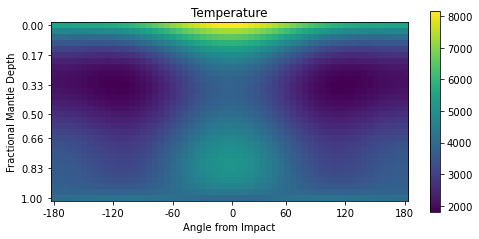

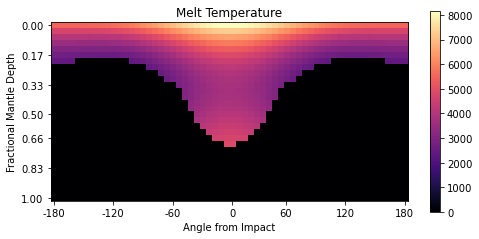

In [103]:
import numpy as np
from MeltModelJupyter import Model
import matplotlib.pyplot as plt; plt.close('all')

m = Model(Mtotal=5, gamma=0.07, vel=1.0, entropy0=1100, impact_angle=40) # m contains all melt model outputs 
resp = m.run_model() #m.du=Temp/100, m.du_gain=deltaT/100, m.du_melt=molten, m.du_gain_melt=molten if T=solidus

plt.figure('TemperatureEx',figsize=(8,6)); plt.title('Temperature'); plt.set_cmap('viridis')
plt.xticks([0,10,20,30,39,49,59],np.arange(-180,240,60)); plt.yticks([0,5,10,15,19,24,29],['0.00','0.17','0.33','0.50','0.66','0.83','1.00'])
plt.xlabel('Angle from Impact'); plt.ylabel('Fractional Mantle Depth')
plt.imshow(m.du[::-1]*100); plt.colorbar(shrink=0.615) # Temperature plot

# plt.savefig('plotsAndStats/TemperatureExample.jpg',dpi=1200)

plt.figure('MeltEx',figsize=(8,6)); plt.title('Melt Temperature'); plt.set_cmap('magma')
plt.xticks([0,10,20,30,39,49,59],np.arange(-180,240,60)); plt.yticks([0,5,10,15,19,24,29],['0.00','0.17','0.33','0.50','0.66','0.83','1.00'])
plt.xlabel('Angle from Impact'); plt.ylabel('Fractional Mantle Depth')
plt.imshow(m.du[::-1]*100*m.du_melt[::-1]); plt.colorbar(shrink=0.615) # Melt Temperature plot

# plt.savefig('plotsAndStats/MeltxTemperatureExample.jpg',dpi=1200)


### Mercury Diagram

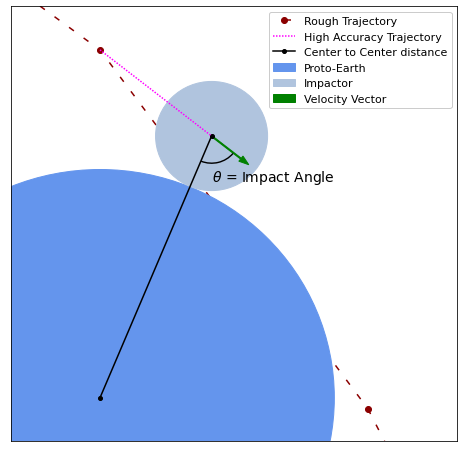

In [107]:
import matplotlib.pyplot as plt; plt.close('all')
import matplotlib as mpl

fig,ax = plt.subplots(figsize=(8,8)); ax.set_xticks([]); ax.set_yticks([]); L=1; plt.xlim([-L,L]); plt.ylim(-L,L)

C1x = -.6; C1y = -.8; C1 = plt.Circle((C1x,C1y),radius=1.05,alpha=1,color='cornflowerblue'); ax.add_patch(C1)
C2x = -.1; C2y = 0.404; C2 = plt.Circle((C2x,C2y),radius=0.251,alpha=1,color='lightsteelblue'); ax.add_patch(C2)

x=[-1,-0.6,0.6,.7]; y=[1.1,0.8,-.85,-1.05]; plt.plot(x,y,'darkred',marker='o',linestyle=(4,(4,8)),zorder=0)
x2 =[x[1],C2x] ; y2 = [y[1],C2y]; plt.plot(x2,y2,'magenta',linestyle=(0,(1,1)),zorder=10)

plt.arrow(C2x,C2y,-(x[1]-C2x)/3,-(y[1]-C2y)/3,width=.005,head_width=.03,length_includes_head=True,color='g')
plt.plot((C1x, C2x),(C1y,C2y),c='k',zorder=4,marker='o',markersize=4)

plt.text(C2x,C2y-.21,r'$\theta$ = Impact Angle',fontsize=14)
Arc = mpl.patches.Arc((C2x,C2y),.25,.25,248,0,72,linewidth=1.4); ax.add_patch(Arc)
plt.legend(['Rough Trajectory','High Accuracy Trajectory','Center to Center distance','Proto-Earth','Impactor','Velocity Vector'],framealpha=1,fontsize=11)

plt.savefig('plotsAndStats/mercury.jpg',dpi=1200)

### Initial Mantle Adiabat

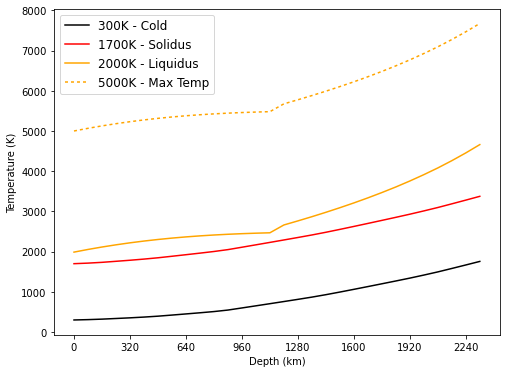

In [1]:
from MeltModelJupyter import Model
import matplotlib.pyplot as plt; plt.close('all')

Lm=7.18e5

plt.figure('Adiabat',figsize=(8,6))
plt.ylabel('Temperature (K)'); plt.xlabel('Depth (km)')
plt.xticks([0,4,8,12,16,20,24,28], [0,320,640,960,1280,1600,1920,2240])

m = Model(3.1023287, gamma=0.01, vel=1, entropy0=1100, impact_angle=90); resp = m.run_model()
plt.plot(100*(m.du-m.du_gain)[::-1].T[0],color='k')
m = Model(3.1023287, gamma=0.01, vel=1, entropy0=3160, impact_angle=90); resp = m.run_model()
plt.plot(100*(m.du-m.du_gain)[::-1].T[0], color='r')
plt.plot(m.tmelt[::-1].T[0]/1000,c='orange')
plt.plot(m.tmelt[::-1].T[0]/1000+(5000-m.tmelt[::-1].T[0,0]/1000),c='orange',linestyle=(0,(2,2)))
plt.legend(['300K - Cold','1700K - Solidus','2000K - Liquidus']+['5000K - Max Temp'],fontsize=12)

# plt.savefig("plotsAndStats\InitTemp.jpg",dpi=1200)

### Mass Plot

Average % accreted by 10 Myr:  0.8090951638404222


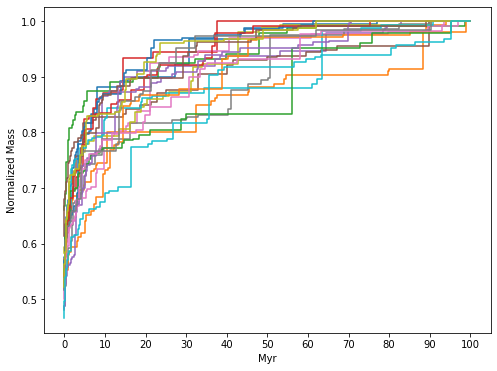

In [32]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')

# 3.1023287 # init Mass

plt.figure('Mass',figsize=(8,6))
plt.xticks(np.arange(0,2e8*365,1e7*365),np.arange(0,200,10))
plt.xlabel('Myr'); plt.ylabel('Normalized Mass')
acc10myr=np.zeros(20)

for i in range(1,21):
    data = np.array([x.strip().split(',') for x in open("Nakajima_Inputs/AccSim"+str(i))][1:])[:,1:].astype(float)
    massSort = np.insert(data[data[:,0].argsort()][:,2],0,3.1023287); massNorm = massSort/massSort[-1]
    dateSort = np.insert(data[data[:,0].argsort()][:,0],0,0)
    datePlt = np.zeros(2*len(dateSort)); massPlt = np.zeros(2*len(massNorm)); datePlt[::2] = dateSort 
    datePlt[1:-1:2] = dateSort[1:]; datePlt[-1] = 100e6*365; massPlt[::2] = massNorm; massPlt[1::2] = massNorm
    plt.plot(datePlt,massPlt)
    acc10myr[i-1]=max(data[data[:,0]<365e7][:,2])/max(data[:,2])
print('Average % accreted by 10 Myr: ',np.average(acc10myr))
# plt.savefig('plotsAndStats/massNorm.jpg',dpi=1200)

### Eccentricity vs Semi Major Axis

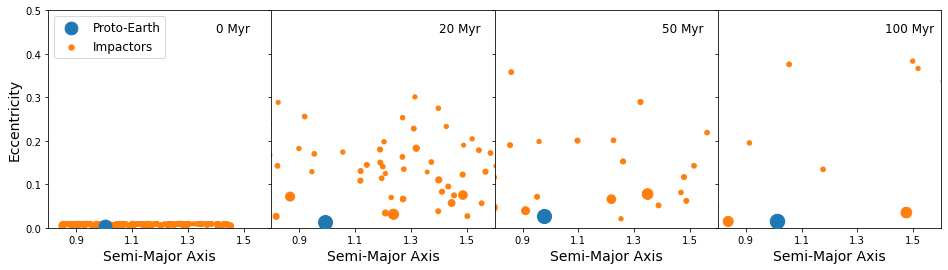

In [12]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')

fig, axs = plt.subplots(1,4,figsize=(16,4),sharey=True,sharex=True)

GM = (1.98847e30)*(6.67430*10**-11)

myr0 = [line.strip() for line in open('../../LONI/Data/Sim10/inputs/big_10init.in')][6:] + [line.strip() for line in open('../../LONI/Data/Sim10/inputs/small_10init.in')][5:]
myr10 = [line.strip() for line in open('../../LONI/Data/Sim10/ProtoECollSim10/big_L3e2535.892.dmp')][6:] + [line.strip() for line in open('../../LONI/Data/Sim10/ProtoECollSim10/small_L3e2535.892.dmp')][5:]
myr50 = [line.strip() for line in open('../../LONI/Data/Sim10/ProtoECollSim10/big_L9e987.752.dmp')][6:] + [line.strip() for line in open('../../LONI/Data/Sim10/ProtoECollSim10/small_L9e987.752.dmp')][5:]
myr100 = [line.strip() for line in open('../../LONI/Data/Sim10/ProtoECollSim10/big_L19e2575.662.dmp')][6:] + [line.strip() for line in open('../../LONI/Data/Sim10/ProtoECollSim10/small_L19e2575.662.dmp')][5:]

for j in range(4): 
    dat= [myr0,myr10,myr50,myr100][j]
    massEccSMA = np.zeros([int((len(dat))/4),3])
    for i in range(int((len(dat))/4)):
        massEccSMA[i,0] = float(dat[4*i].split('m=')[1].split()[0]) * (1.98847e30)
        pos = [float(x)*149597870691 for x in dat[1+4*i].split()] # m to au # 
        vel = [float(x)*149597870691/86400 for x in dat[2+4*i].split()] #
        angMoment = np.cross(pos,vel); angMomentNorm = np.linalg.norm(angMoment)
        velNorm = np.linalg.norm(vel); posNorm = np.linalg.norm(pos)
        specOE = 0.5*velNorm**2 - GM/posNorm
        massEccSMA[i,1] = np.sqrt(1+2*specOE*(angMomentNorm**2)/GM**2)
        massEccSMA[i,2] = -GM/2/specOE
        
    axs[j].set_xlabel('Semi-Major Axis',fontsize=14)
    axs[j].set_xticks([0.9,1.1,1.3,1.5])
    axs[j].scatter(massEccSMA[0,2]/149597870691,massEccSMA[0,1],marker='.',zorder=100,s=((np.log(massEccSMA[0,0])-21)/22)**14)
    axs[j].scatter(massEccSMA[1:,2]/149597870691,massEccSMA[1:,1],marker='.',s=((np.log(massEccSMA[1:,0])-21)/22)**14); 
axs[0].legend(['Proto-Earth','Impactors'],loc='upper left',fontsize=12)
plt.axis([0.8,1.6,0,0.5])
axs[0].set_ylabel('Eccentricity',fontsize=14)
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].text(1.4,.45,'0 Myr',fontsize=12); axs[1].text(1.4,.45,'20 Myr',fontsize=12); axs[2].text(1.4,.45,'50 Myr',fontsize=12); axs[3].text(1.4,.45,'100 Myr',fontsize=12);

# plt.savefig('plotsAndStats/EccVsSMA.jpg',dpi=1200)

### Steam Model 

sim 5 Mo lengths: [ 122750.  482025.  586875. 1362750.]


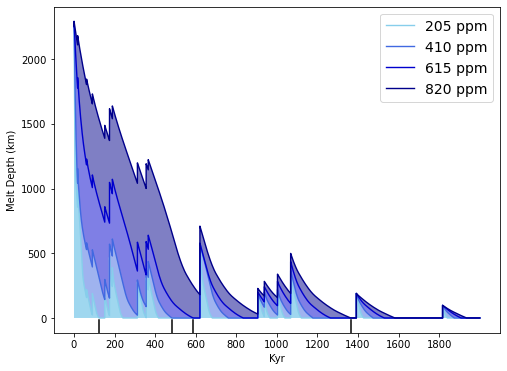

In [4]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')

if(LoadConstantModel): print('Please Load Steam Model Data')
else: # melt vs ppm for sim 5, molten, 2myr
    f, ax = plt.subplots(figsize=(8,6)); ax.set_prop_cycle(color=['skyblue','royalblue','mediumblue','darkblue']); 
    
    xt25 = 80000; sim0=4; qMo=np.zeros(4)
    for i in range(4):
        plt.plot(AllMelt[2][i][sim0][0:xt25],linewidth=1.4)
        if(i>0): plt.fill_between(range(xt25),AllMelt[2][i][sim0][0:xt25],AllMelt[2][i-1][sim0][0:xt25],alpha=0.5)
        elif(i==0): plt.fill_between(range(xt25),AllMelt[2][0][sim0][0:xt25],alpha=0.8)
        x=np.nonzero(AllMelt[2][i][sim0]); qMo[i]=(np.nonzero(((x[0][1:]-x[0][:-1]))-1)[0])[0]
        
    plt.xlabel('Kyr'); plt.ylabel('Melt Depth (km)'); #plt.title('Sim '+str(sim0+1)+', Molten - Melt vs PPM')
    plt.xticks(np.arange(0,2*1e6/25,2e5/25),np.arange(0,2000,200)); plt.legend([w+' ppm' for w in ['205','410','615','820']],fontsize=14)
    [plt.axvline(q, ymax=0.04,c='k') for q in qMo]; print("sim 5 Mo lengths:",qMo*25)
    
    plt.savefig('plotsAndStats/Sim'+str(sim0+1)+'MoMeltVsPPM.jpg',dpi=1200)

### Melt vs Initial Temp

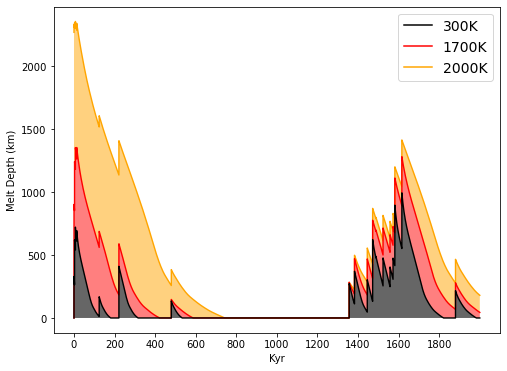

In [3]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')

if(LoadConstantModel): 
    print('Please Load Steam Model Data')
#     sim0=4 # 60W/m^2 - Initial Temp vs Melt
#     f, ax = plt.subplots(figsize=fsize); ax.set_prop_cycle(color=['k','darkred','r']) 
#     plt.xlabel('Myr'); plt.ylabel('Melt Depth (km)'); plt.xticks(np.arange(0,2*1e8/25,1e7/25),np.arange(0,200,10))
#     [plt.plot(AllMelt[i][1][sim0]) for i in range(3)]; plt.legend(['300K','1700K','2000K']); plt.title('Sim '+str(sim0+1)+', 60W/m^2 - Initial Temp vs Melt')
# #         plt.savefig('plotsAndStats/Sim'+str(sim0+1)+'TempVsMelt.jpg',dpi=1200); plt.show()

else: # melt vs temp for sim 10, 820ppm, 2myr
    xt25 = 80000; sim0=9
    f, ax = plt.subplots(figsize=(8,6)); cyc=['k','r','orange']  #['crimson','orangered','darkorange']
    ax.set_prop_cycle(color=cyc); #plt.title('Sim '+str(sim0+1)+', 820 ppm Steam Model - Melt vs Temp')
    plt.xlabel('Kyr'); plt.ylabel('Melt Depth (km)'); plt.xticks(np.arange(0,2*1e6/25,2e5/25),np.arange(0,2000,200))
    [plt.plot(i) for i in range(3)]; plt.legend(labels=['300K','1700K','2000K'],fontsize=14)
    for i in range(3):
        plt.plot(AllMelt[i][3][sim0][0:xt25],color=cyc[i],zorder=99-i,linewidth=1.4)
        if(i>0): plt.fill_between(range(xt25),AllMelt[i][3][sim0][0:xt25],AllMelt[i-1][3][sim0][0:xt25],alpha=0.5)
        elif(i==0): plt.fill_between(range(xt25),AllMelt[0][3][sim0][0:xt25],alpha=0.6)

#     plt.savefig('plotsAndStats/Sim'+str(sim0+1)+'w820MeltVsTemp.jpg',dpi=1200)

### Final Atmosphere

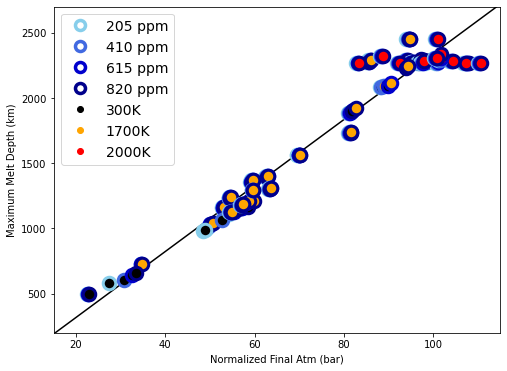

In [123]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')
import matplotlib as mpl

if(LoadConstantModel): print('Please Load Steam Model Data')
else: # melt vs temp for sim 10, 820ppm, 2myr
    f, ax = plt.subplots(figsize=(8,6)); cyc=['k','orange','r']; cyc2=['skyblue','royalblue','mediumblue','darkblue']

    dat=[]; dat=np.array(dat)
    for i in range(20):
        for j in range(4):
            for k in range(3):
                dat=np.append(dat,(FinalAtm[k][j][i]/(j+1),np.max(AllMelt[k][j][i])))
                plt.plot(FinalAtm[k][j][i]/(j+1),np.max(AllMelt[k][j][i]),'.',markersize=25,markeredgewidth=3,markerfacecolor=cyc[k],color=cyc2[j])

    m,b=np.polyfit(np.array(dat).reshape(-1)[::2], np.array(dat).reshape(-1)[1::2],1)
    plt.plot([0,140],m*np.array([0,140])+b,zorder=0,c='k'); plt.xlim(15,115); plt.ylim(200,2700)    
#     plt.text(70,650,'y = '+str(np.round(m,2))+'x - '+str(np.round(-b,2)),fontsize=14)
    plt.ylabel('Maximum Melt Depth (km)'); plt.xlabel('Normalized Final Atm (bar)')

    plt.legend(handles=[mpl.lines.Line2D([0],[0],marker='o',markersize=10,linestyle='',markerfacecolor='w',markeredgewidth=3.5,color=cyc2[0],label='205 ppm'),
                        mpl.lines.Line2D([0],[0],marker='o',markersize=10,linestyle='',markerfacecolor='w',markeredgewidth=3.5,color=cyc2[1],label='410 ppm'),
                        mpl.lines.Line2D([0],[0],marker='o',markersize=10,linestyle='',markerfacecolor='w',markeredgewidth=3.5,color=cyc2[2],label='615 ppm'),
                        mpl.lines.Line2D([0],[0],marker='o',markersize=10,linestyle='',markerfacecolor='w',markeredgewidth=3.5,color=cyc2[3],label='820 ppm'),
                        mpl.lines.Line2D([0],[0],marker='o',color='k',label='300K',linestyle=''),
                        mpl.lines.Line2D([0],[0],marker='o',color='orange',label='1700K',linestyle=''),
                        mpl.lines.Line2D([0],[0],marker='o',color='r',label='2000K',linestyle='')], loc='upper left',fontsize=14) #mpl.lines.Line2D([1],[1],color='k',label='Regression')

#     plt.savefig('plotsAndStats/FinalAtmAll.jpg',dpi=1200)

# Old version
# if(1):
#     f, ax = plt.subplots(figsize=fsize) ; EO = 265 # earth oceans -> bar        
#     cyc= ['r','darkred','k'] #['crimson','orangered','darkorange'][::-1] #['mediumvioletred','purple',"steelblue"]; 
#     ax.set_prop_cycle(color=cyc) 
#     [plt.scatter([0,1,2,3],FinalAtm[i,:,0],30,marker='o',color=cyc[2-i],zorder=9+i) for i in range(3)] #facecolor='white'
#     plt.legend(['Cold','Hot','Molten']*0+1*['300K','1700K','2000K'],fontsize=14)
#     [plt.plot([0,1,2,3],sum(FinalAtm[i].T)/20,ls=':') for i in [2,1,0]] # average line
#     [[plt.scatter([0,1,2,3],FinalAtm[j,:,i],30,color=cyc[2-j],marker='o') for i in range(1,20)] for j in range(3)] #,facecolor="white"
#     plt.xticks(np.arange(0,4),[w+' ppm' for w in ['205','410','615','820']]); plt.xlabel('Initial H2O'); plt.ylabel('Pressure (bar)')
#     plt.axhline(EO,color='gray',ls='dashed'); plt.title('Final Atmosphere vs Steam Model')
# #         if(Saving): plt.savefig('plotsAndStats/FinalAtmAll.jpg',dpi=1200); plt.show()

### CO2 Model 

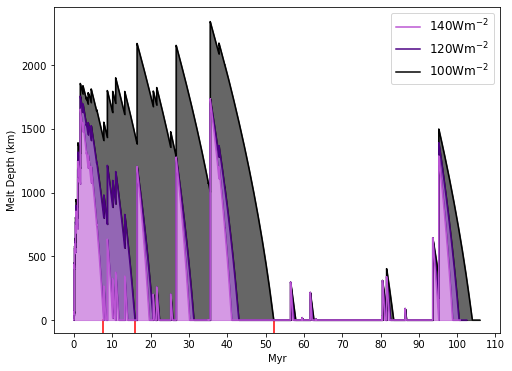

In [7]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')

if(1-LoadConstantModel): print('Please Load CO2 Model Data')
else:
    moFin=np.zeros(3); cyc=['mediumorchid','indigo','k']; T=1; sim0=19 # 0:19 -> sim 20
    f, ax = plt.subplots(figsize=(8,6)); plt.xticks(np.arange(0,2*1e8/25,1e7/25),np.arange(0,200,10))

    for i in range(3):   
        x=np.nonzero(AllMelt[T][i][sim0]); q=(np.nonzero(((x[0][1:]-x[0][:-1]))-1)[0]); 
        if (len(q)<2): moFin[i]=q[0]
        else: moFin[i]=max(max(q[1:]-q[:-1]),q[0])
        if(i==0): plt.fill_between(range(len(AllMelt[T][i][sim0])),AllMelt[T][i][sim0],alpha=0.6, color=cyc[i])
        else: plt.fill_between(range(len(AllMelt[T][i][sim0])),AllMelt[T][i][sim0],np.append(AllMelt[T][i-1][sim0],np.zeros(len(AllMelt[T][i][sim0])-len(AllMelt[T][i-1][sim0]))),alpha=0.6, color=cyc[i])
        plt.plot(AllMelt[T][i][sim0],color=cyc[i],zorder=99-i)
    
    plt.legend([w+ '$\mathrm{Wm^{-2}}$' for w in ['140','120','100']],fontsize=12); plt.ylim(bottom=-1e2)  # plt.title('Sim '+str(sim0+1)+' Molten - Flux vs Melt')
    [plt.plot([moFin[i],moFin[i]],[0,-1e2],zorder=0,c='r') for i in [0,1,2]]; plt.xlabel('Myr'); plt.ylabel('Melt Depth (km)')
    
    plt.savefig('plotsAndStats/Sim'+str(sim0+1)+'ConstVsMelt.jpg',dpi=1200)

### Largest Impact

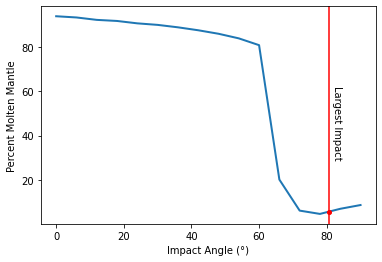

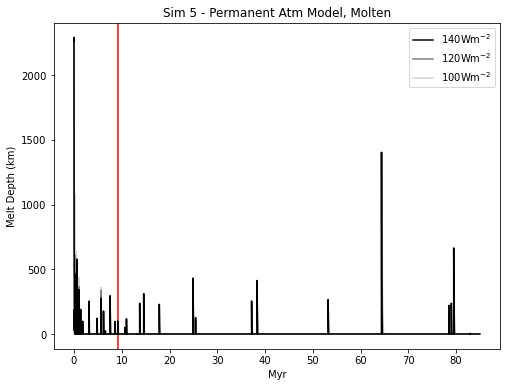

In [61]:
import numpy as np
from MeltModelJupyter import Model
import matplotlib.pyplot as plt; plt.close('all')

m = Model(LI[2], gamma=LI[4], vel=LI[3], entropy0=3160, impact_angle=LI[1]); resp = m.run_model()
oblMelt=np.sum(m.dv*m.du_melt)/np.sum(m.dv)*100; x=np.linspace(0,90,16)
if('y_MvA' not in globals() or y_MvA[-1]==0): # prevent double loading data
    y_MvA=np.zeros(len(x))
    for i in range(0,len(x)):
        m = Model(LI[2], gamma=LI[4], vel=LI[3], entropy0=3160, impact_angle=x[i]); resp = m.run_model() 
        y_MvA[i]=np.round(np.sum(m.dv*m.du_melt)/np.sum(m.dv),4)*100

plt.plot(x,y_MvA,linewidth=2); plt.plot(LI[1],oblMelt,'.',color='r',markersize=8); plt.axvline(LI[1],color='r')
plt.text(LI[1]+1,30,'Largest Impact',rotation=-90); plt.xlabel('Impact Angle (°)'); plt.ylabel('Percent Molten Mantle')

# plt.savefig('plotsAndStats/MeltvsAngle.jpg',dpi=1200); plt.show()

# if(0): # shows where impact landed in melt profile
#     f, ax = plt.subplots(figsize=(8,6)); ax.set_prop_cycle(color=['black','grey','lightgrey'])
#     plt.xlabel('Myr'); plt.ylabel('Melt Depth (km)'); plt.xticks(np.arange(0,2*1e8/25,1e7/25),np.arange(0,200,10))
#     [plt.plot(AllMelt[2][i][4],zorder=(3-i)) for i in range(3)]
#     plt.legend([w+ '$\mathrm{Wm^{-2}}$' for w in ['140','120','100']])
#     plt.axvline(366358.93,ymin=0,ymax=1,color='red') # largest impact sim 5, imp 27
# #     plt.savefig('plotsAndStats/Sim5LgImpact.jpg',dpi=1200); plt.show()

In [ ]:
# build folders for stats and plot output, automate plot generation

## Mantle Water 
# if(0):
#     f, ax = plt.subplots(figsize=fsize)
#     ax.set_prop_cycle(color=['skyblue','royalblue','mediumblue','indigo']); plt.legend(['215','410','615','820'])
#     [ plt.plot(sum(MantleW[2,i]/20)/(i+1)/(sum(MantleW[2,0]/20))*100) for i in [0,1,2,3]]      
    
## Individual atmosphere (add melt) plots
# plt.close('all')
# print('\nPlotting All Atm:')
# for i in range(0,len(AllAtm)):
#     for j in range(0,len(AllAtm[i])):
#         for k in range(0,len(AllAtm[i][j])):
#             plt.close('all')
#             plt.figure((i*80)+(j*20)+(k+1))
#             plt.plot(AllAtm[i][j][k]) # [Temp][H2O][Sim]
# #             plt.show()

## Plot all sims for const atm model, molten
# if(LoadConstantModel): 
#     for i in range(20): #[5,11,19,14]: #range(20):
#         print('Sim'+str(i+1))
#         f, ax = plt.subplots(figsize=fsize)
#         cyc=['crimson','orangered','darkorange']
#         ax.set_prop_cycle(color=cyc); # plt.title('Sim '+str(sim0+1)+' - Melt vs Temp')
#         plt.xticks(np.arange(0,2*1e8/25,1e7/25),np.arange(0,200,10))
#         [plt.plot(AllMelt[2-melt][1][i]) for melt in range(3)]; plt.show()

## plot all loaded sims
# if(0): 
#     for i in [0]: #range(20):
#         print('Sim'+str(i+1))
#         if(LoadConstantModel): # Plot all sims for const atm model, molten
#             plt.xticks(np.arange(0,2*1e8/25,1e7/25),np.arange(0,200,10))
#             [plt.plot(AllMelt[2][olr][i]) for olr in range(3)]; plt.show()
#         else: # Plot all sims for 820 ppm, molten
#             plt.xticks(np.arange(0,2*1e7/25,1e6/25),np.arange(0,200,10))
#             plt.plot(AllMelt[2][3][i][0:160000]); plt.show()
            